In [ ]:
import os
import h5py
import numpy as np
import math

from scipy.ndimage import median_filter, gaussian_filter, zoom
from skimage import exposure
from scipy.signal import fftconvolve
from skimage.feature import peak_local_max
%matplotlib inline
import matplotlib.pyplot as plt
from helpers import sech, normalize, ipf3D, convolution3D_FFTdomain, chiimg3D_FFT, findpeaks3D, pgrid3D, cidp23D, CircleOverlap,CircleDetection,find_peaks,RemoveArtifacts

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from scipy.ndimage import maximum_filter

from skimage.transform import probabilistic_hough_line

from math import hypot, acos, sqrt, pi

from skimage.draw import disk
from skimage.segmentation import morphological_geodesic_active_contour as mgac
from skimage.filters import sobel
from skimage.restoration import inpaint

In [9]:
import h5py
import math

import numpy as np
import matplotlib.pyplot as plt

from helpers import sech, normalize, ipf3D, convolution3D_FFTdomain, chiimg3D_FFT, findpeaks3D, pgrid3D, cidp23D, CircleOverlap,CircleDetection,find_peaks,RemoveArtifacts
from scipy.ndimage import median_filter, gaussian_filter, zoom
from skimage import exposure
from skimage.feature import canny


In [ ]:
CircleDetection
RemoveArtifacts

In [3]:
filePath = r"C:\Users\Lab User\Desktop\experiment data\07292025\Scan_4.hdf5"
dataPath = f'/RawData/Scan_4'

with h5py.File(filePath,'r') as f: 
    data = f[dataPath][()] # (slices, rows, width)
data = np.transpose(data,[1,2,0]) # (rows, width, slices)
dataCropped = data[150:1100,50:970,:]
cR, cW, cZ = np.shape(dataCropped)

In [4]:
highPct, medPct = 99, 95

# Apply median filter and threshold
threshHigh = np.percentile(dataCropped, highPct)
filteredData = median_filter(dataCropped, size=(3, 3, 3))
dataCropped[dataCropped > threshHigh] = filteredData[dataCropped > threshHigh]

# Update threshold and replace values above it with the median
threshHigh = np.percentile(dataCropped, highPct)
dataCropped[dataCropped > threshHigh] = np.mean(np.percentile(dataCropped, medPct))


In [5]:
meanPerCol = np.mean(dataCropped,axis=(1,2))
meanCenterRow = meanPerCol[math.floor(cR/2)]
scales = meanCenterRow/meanPerCol

dataColNorm = dataCropped*scales[:, np.newaxis, np.newaxis]
dataNorm = np.clip(exposure.rescale_intensity(dataColNorm, in_range='image', out_range=(0,1)), 0, 1)

blurred = gaussian_filter(dataNorm, sigma=3)
strength = 0.2
dataSharp = np.clip(dataNorm + strength * blurred, 0, 1)

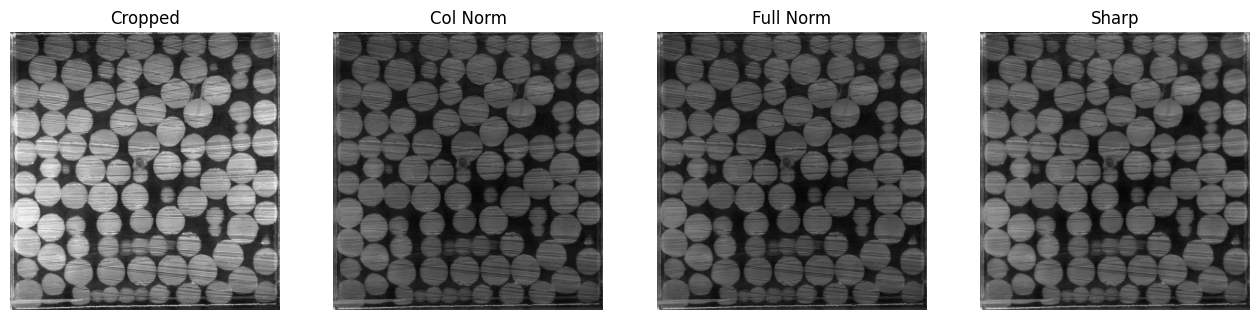

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4)) 
ax1, ax2, ax3, ax4 = axs.flatten()

ax1.imshow(dataCropped[:, :, math.floor(cZ/2)], cmap='gray')
ax1.set_title('Cropped')

ax2.imshow(dataColNorm[:, :, math.floor(cZ/2)], cmap='gray')
ax2.set_title('Col Norm')

ax3.imshow(dataNorm[:, :, math.floor(cZ/2)], cmap='gray')
ax3.set_title('Full Norm')

ax4.imshow(dataSharp[:, :, math.floor(cZ/2)], cmap='gray')
ax4.set_title('Sharp')

for ax in axs:
    ax.axis('off')

plt.show()


In [17]:
# Run algorithm
mid = dataSharp[:,:,math.floor(cZ/2)+150]
image = mid

In [12]:
def SphereDetection(
    volume,
    min_r=10,
    max_r=60,
    step=2,
    sigma=2.75,
    threshold=100,
    iou_thresh=0.25
):
    # Edge detection
    edges = np.array([canny(img,sigma=sigma) for img in volume])
    print(np.shape(edges))
    h, w = edges.shape

SphereDetection(dataSharp)

(950, 920, 852)


ValueError: too many values to unpack (expected 2)

In [ ]:
def SphereDetection(
    volume,
    min_r=10,
    max_r=60,
    step=2,
    sigma=2.75,
    threshold=100,
    iou_thresh=0.25
):
    # Edge detection
    edges = [canny(img,sigma=sigma) for img in volume]
    h, w = edges.shape

    # Radii
    radii = np.arange(min_r, max_r, step)
    num_radii = len(radii)

    # Precompute circle perimeters (stacked)
    theta = np.arange(0, 2 * pi, pi / 180)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    dx_all = np.round(radii[:, None] * cos_t).astype(int)
    dy_all = np.round(radii[:, None] * sin_t).astype(int)

    # Voting
    y_idxs, x_idxs = np.nonzero(edges)  # edge points (N,)
    N = len(x_idxs)

    # Expand edge coords against circle offsets
    # Shape: (num_radii, N, num_theta)
    x_c = x_idxs[None, :, None] - dx_all[:, None, :]
    y_c = y_idxs[None, :, None] - dy_all[:, None, :]

    # Keep only valid centers
    valid = (x_c >= 0) & (x_c < w) & (y_c >= 0) & (y_c < h)

    # Flatten into 1D indices for bincount
    flat_idx = (y_c * w + x_c) * num_radii + np.arange(num_radii)[:, None, None]
    flat_idx = np.where(valid, flat_idx, -1).ravel()

    flat_idx = flat_idx[flat_idx >= 0]  # remove invalid

    accumulator = np.bincount(flat_idx, minlength=h * w * num_radii).reshape(h, w, num_radii)

    # Candidate detection
    candidates = []
    for r_index, r in enumerate(radii):
        acc_slice = accumulator[:, :, r_index]
        local_max = (maximum_filter(acc_slice, size=5) == acc_slice)
        mask = (acc_slice > threshold) & local_max
        coords = np.argwhere(mask)

        if coords.size > 0:
            vals = acc_slice[coords[:, 0], coords[:, 1]]
            for (y, x), val in zip(coords, vals):
                neighbors = []
                for offset in [-2, -1, 1, 2]:
                    neighbor_idx = r_index + offset
                    if 0 <= neighbor_idx < num_radii:
                        neighbors.append(accumulator[y, x, neighbor_idx])
                if all(val > n for n in neighbors):
                    candidates.append((x, y, r, val))

    # IoU filtering
    final_circles = []
    for x, y, r, val in sorted(candidates, key=lambda c: -c[3]):
        this_circle = (x, y, r)
        keep = True
        for fx, fy, fr in final_circles:
            if CircleOverlap(this_circle, (fx, fy, fr)) > iou_thresh:
                keep = False
                break
        if keep:
            final_circles.append(this_circle)

    return final_circles

In [ ]:
def CircleDetection(
    img,
    min_r=10,
    max_r=60,
    step=2,
    sigma=2.75,
    threshold=100,
    iou_thresh=0.25
):
    # Edge detection
    edges = canny(img, sigma=sigma)
    h, w = edges.shape

    # Radii
    radii = np.arange(min_r, max_r, step)
    num_radii = len(radii)

    # Precompute circle perimeters (stacked)
    theta = np.arange(0, 2 * pi, pi / 180)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    dx_all = np.round(radii[:, None] * cos_t).astype(int)
    dy_all = np.round(radii[:, None] * sin_t).astype(int)

    # Voting
    y_idxs, x_idxs = np.nonzero(edges)  # edge points (N,)
    N = len(x_idxs)

    # Expand edge coords against circle offsets
    # Shape: (num_radii, N, num_theta)
    x_c = x_idxs[None, :, None] - dx_all[:, None, :]
    y_c = y_idxs[None, :, None] - dy_all[:, None, :]

    # Keep only valid centers
    valid = (x_c >= 0) & (x_c < w) & (y_c >= 0) & (y_c < h)

    # Flatten into 1D indices for bincount
    flat_idx = (y_c * w + x_c) * num_radii + np.arange(num_radii)[:, None, None]
    flat_idx = np.where(valid, flat_idx, -1).ravel()

    flat_idx = flat_idx[flat_idx >= 0]  # remove invalid

    accumulator = np.bincount(flat_idx, minlength=h * w * num_radii).reshape(h, w, num_radii)

    # Candidate detection
    candidates = []
    for r_index, r in enumerate(radii):
        acc_slice = accumulator[:, :, r_index]
        local_max = (maximum_filter(acc_slice, size=5) == acc_slice)
        mask = (acc_slice > threshold) & local_max
        coords = np.argwhere(mask)

        if coords.size > 0:
            vals = acc_slice[coords[:, 0], coords[:, 1]]
            for (y, x), val in zip(coords, vals):
                neighbors = []
                for offset in [-2, -1, 1, 2]:
                    neighbor_idx = r_index + offset
                    if 0 <= neighbor_idx < num_radii:
                        neighbors.append(accumulator[y, x, neighbor_idx])
                if all(val > n for n in neighbors):
                    candidates.append((x, y, r, val))

    # IoU filtering
    final_circles = []
    for x, y, r, val in sorted(candidates, key=lambda c: -c[3]):
        this_circle = (x, y, r)
        keep = True
        for fx, fy, fr in final_circles:
            if CircleOverlap(this_circle, (fx, fy, fr)) > iou_thresh:
                keep = False
                break
        if keep:
            final_circles.append(this_circle)

    return final_circles

In [18]:
circles = CircleDetection(img_as_ubyte(image),threshold=60)

NameError: name 'img_as_ubyte' is not defined

In [ ]:
clean = RemoveArtifacts(mid, circles)

In [ ]:
clean_bin = np.copy(clean)
clean_bin[clean_bin<.3] =0
clean_bin[clean_bin>=.3]=1

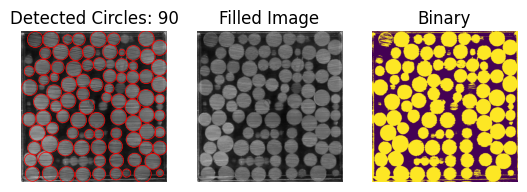

In [ ]:
# Plot results
fig, axs = plt.subplots(1,3)
ax1, ax2, ax3 = axs.flatten()

ax1.imshow(image, cmap='gray')
ax2.imshow(clean, cmap='gray')
ax3.imshow(clean_bin)

for x, y, r in circles:
    circle = plt.Circle((x, y), r, color='red', fill=False, linewidth=.5)
    ax1.add_patch(circle)

for ax in axs:
    ax.set_axis_off()

ax1.set_title(f"Detected Circles: {len(circles)}")
ax2.set_title("Filled Image")
ax3.set_title("Binary")

plt.show()

Text(0.5, 1.0, 'Binary Filled')

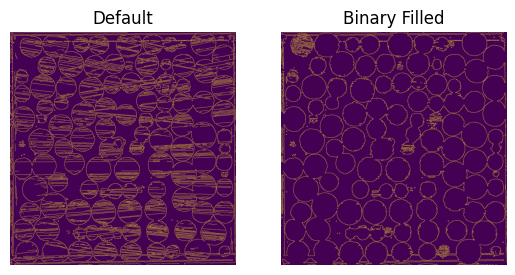

In [ ]:
fig, axs = plt.subplots(1,2)
ax1,ax2 =axs.flatten()

ax1.imshow(canny(image))
ax2.imshow(canny(clean_bin))

for ax in axs:
    ax.set_axis_off()

ax1.set_title('Default')
ax2.set_title('Binary Filled')

In [ ]:
plt.hist(image)


NameError: name 'plt' is not defined

In [ ]:
# Downsample
scaleFactor = 0.5
dataRescale = zoom(dataSharp, scaleFactor, order=1)

In [ ]:

# Particle detection

D, w = 100*scaleFactor, 2.5*scaleFactor
Cutoff, MinSep = 5, 75*scaleFactor
ss = int(2*(D/2 + 4*w/2)-1)
os = (ss-1)//2
xx, yy, zz = np.meshgrid(np.arange(-os,os+1), np.arange(-os,os+1), np.arange(-os,os+1), indexing='ij')
r = np.sqrt(xx**2 + yy**2 + zz**2)
ipi = ipf3D(r, D, w)
chi3D, _ = chiimg3D_FFT(dataRescale, ipi)
Np, px, py, pz = findpeaks3D(1./(chi3D+1e-12), Cutoff=Cutoff, MinSep=MinSep)

In [ ]:
# Sub-voxel refinement
cxyz, over = pgrid3D(px, py, pz, dataRescale.shape[1], dataRescale.shape[0], dataRescale.shape[2], Np, os, 0)
r_full = np.sqrt(cxyz.x**2 + cxyz.y**2 + cxyz.z**2)
ci = ipf3D(r_full, D, w)
di = ci - dataRescale
chi2 = np.sum(di**2)

nr, delchi2, mindelchi2, maxnr = 0, 1e99, 1, 5
while abs(delchi2)>mindelchi2 and nr<maxnr:
    dpx, dpy, dpz = cidp23D(cxyz, over, di, Np, D, w)
    px += dpx; py += dpy; pz += dpz
    cxyz, over = pgrid3D(px, py, pz, dataRescale.shape[1], dataRescale.shape[0], dataRescale.shape[2], Np, os, 0)
    r_full = np.sqrt(cxyz.x**2 + cxyz.y**2 + cxyz.z**2)
    ci = ipf3D(r_full, D, w)
    di = ci - dataRescale
    delchi2 = chi2 - np.sum(di**2)
    chi2 -= delchi2
    nr += 1

In [ ]:

# Visualization

# Max projection of residual
plt.figure()
plt.imshow(np.max(di**2, axis=2), cmap='gray', origin='lower')
plt.colorbar()
plt.title(f'Residual Chi^2 (max projection), Chi2={chi2:.2f}')
plt.show()

In [ ]:
# 3D scatter of particle centers
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(px, py, pz, c='r', s=50)
ax.set_xlim(0, dataRescale.shape[1])
ax.set_ylim(0, dataRescale.shape[0])
ax.set_zlim(0, dataRescale.shape[2])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Detected particle centers')
plt.show()
